### Goal is compare size and accuracy of various models on finance sentiment and deciding final model for deployment

In [1]:
#basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import datasets
import transformers
from tqdm import tqdm

In [2]:
#load dataset
#loading instances where 2/3 annotators agreed
from datasets import load_dataset
news_sent = load_dataset('takala/financial_phrasebank','sentences_66agree')

In [3]:
news_sent = news_sent['train'].train_test_split(train_size=0.8)

In [4]:
news_sent

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 3373
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 844
    })
})

### Exploring dataset

In [5]:
news_sent.set_format("pd")

In [6]:
df = news_sent['train'][:]

In [7]:
df.head()

,sentence,label
0,CS Cabot 's main consumers on the Czech and Sl...,1
1,The brokerage said 2006 has seen a ` true turn...,2
2,A merger between UPM and Finnish-Swedish Stora...,1
3,Thanksto improvements in demand and the adjust...,2
4,The company had net sales of EUR 10.8 million ...,1


### extract meaning of labels from dataset

In [8]:
def int2str_row(row):
    return news_sent['train'].features['label'].int2str(row)

In [9]:
df['sentiment'] = df['label'].apply(int2str_row)

In [10]:
df.head()

,sentence,label,sentiment
0,CS Cabot 's main consumers on the Czech and Sl...,1,neutral
1,The brokerage said 2006 has seen a ` true turn...,2,positive
2,A merger between UPM and Finnish-Swedish Stora...,1,neutral
3,Thanksto improvements in demand and the adjust...,2,positive
4,The company had net sales of EUR 10.8 million ...,1,neutral


In [11]:
df['sentiment'].value_counts()

sentiment
neutral     2036
positive     936
negative     401
Name: count, dtype: int64

### 1 -> neutral 2->positive 0->negative

In [12]:
df['wrd_len'] = df['sentence'].str.split().apply(len)

### words per sentence

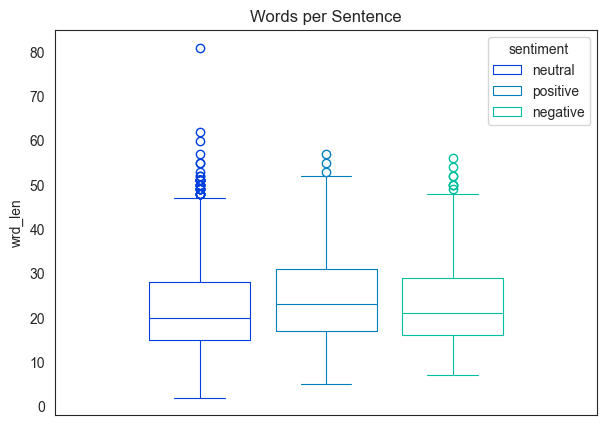

In [13]:
plt.figure(figsize=(7,5))
sns.set_style('white')
sns.boxplot(y='wrd_len',data=df,width=0.7,gap=0.2,fill=False,hue='sentiment',linewidth=0.8,palette='winter')
plt.title('Words per Sentence')
plt.show()
#every sentiment news has around 50 words which is a lot less than context length of 512

/var/folders/xw/knd54pd91c7cw57n21dntvx80000gn/T/ipykernel_59050/668373761.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment',data=df,width=0.5,gap=0.2,palette='winter')


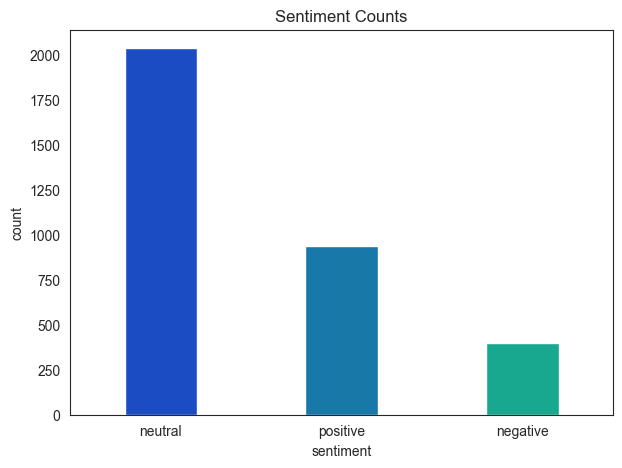

In [14]:
plt.figure(figsize=(7,5))
sns.set_style('white')
sns.countplot(x='sentiment',data=df,width=0.5,gap=0.2,palette='winter')
plt.title('Sentiment Counts')
plt.show()

### Reset format

In [15]:
news_sent.reset_format()

### load tokenizer

### First model we will be using is DistilBERT

In [16]:
bert_path = 'bert-base-uncased'

In [17]:
#distilbert is a distiled version of BERT model
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(bert_path)

In [18]:
out = tokenizer("a sample text for testing tokenizer of bert")
tokenizer.convert_ids_to_tokens(out['input_ids'])

['[CLS]',
 'a',
 'sample',
 'text',
 'for',
 'testing',
 'token',
 '##izer',
 'of',
 'bert',
 '[SEP]']

In [19]:
def apply_tokenizer(batch):
    return tokenizer(batch['sentence'],padding=True,truncation=True)

In [20]:
news_sent = news_sent.map(apply_tokenizer,batched=True,batch_size=None)

Map:   0%|          | 0/3373 [00:00<?, ? examples/s]

Map:   0%|          | 0/844 [00:00<?, ? examples/s]

In [21]:
#set tensor format
news_sent.set_format('pt',columns=['input_ids','attention_mask','label'])

In [22]:
#structure of dataset
news_sent

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3373
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 844
    })
})

In [23]:
#looking at a sample
news_sent['train'][0]


{'label': tensor(1),
 'input_ids': tensor([  101, 20116,  9298,  4140,  1005,  1055,  2364, 10390,  2006,  1996,
          5569,  1998, 12747,  3006,  2024, 13310,  6443,  3347,  2819,  6803,
          1998, 22640,  7983,  6803,  1012,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,   

### load model

In [24]:
#set appropriate device
from transformers import AutoModelForSequenceClassification
device = torch.device("mps")
#specify num labels for classification head
num_labels = 3
model = (AutoModelForSequenceClassification.from_pretrained(bert_path,num_labels=num_labels).to(device))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
#distilbert has aroung 60 M parameters
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### define metrics for training

In [26]:
# we will be using weighted f1 score and accuracy
from sklearn.metrics import f1_score,accuracy_score
def compute_metrics(pred):
    preds = pred.predictions.argmax(-1)
    labels = pred.label_ids
    f1 = f1_score(labels,preds,average='weighted')
    acc = accuracy_score(labels,preds)
    return {'f1':f1,'acc':acc}  

### Setting Training Parameters

In [27]:
from transformers import TrainingArguments
#set name of new model
model_name = 'FIN_BERT_sentiment'
#set batch size
batch_size = 16
#number of logging steps
loggin_steps = len(news_sent['train'])//batch_size
#epochs and learning rate
num_train_epochs = 5
#set a relatively low learning rate to avoid overfitting
learning_rate = 2e-5
#weight decay helps regularizing
weight_decay = 0.01
#create instance of trainargs
training_args = TrainingArguments(output_dir=model_name,
                                 per_device_eval_batch_size=batch_size,
                                 per_device_train_batch_size=batch_size,
                                 logging_steps=loggin_steps,
                                 num_train_epochs=num_train_epochs,
                                 weight_decay=weight_decay,
                                 log_level="error",
                                 eval_strategy="epoch",
                                 disable_tqdm=False,
                                 push_to_hub=True,
                                 learning_rate=learning_rate)

### create trainier using Trainer from HF

In [28]:
from transformers import Trainer
trainer = Trainer(model=model,
                 args=training_args,
                 compute_metrics=compute_metrics,
                 train_dataset=news_sent['train'],
                 eval_dataset=news_sent['test'])

In [29]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Acc
1,0.529500,0.375707,0.873097,0.872038
2,0.217400,0.311658,0.891136,0.890995
3,0.112900,0.406586,0.888596,0.887441
4,0.045900,0.492260,0.889640,0.888626
5,0.027500,0.490539,0.889069,0.888626


TrainOutput(global_step=1055, training_loss=0.18576166217361018, metrics={'train_runtime': 577.322, 'train_samples_per_second': 29.212, 'train_steps_per_second': 1.827, 'total_flos': 1300021813471500.0, 'train_loss': 0.18576166217361018, 'epoch': 5.0})

In [30]:
trainer.push_to_hub(commit_message='DONEE')

events.out.tfevents.1733331298.Aadityas-MacBook-Pro.local.59050.0:   0%|          | 0.00/8.44k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Sharpaxis/FIN_BERT_sentiment/commit/e4794582b23ffc3ca4f32b8d58e27dfb6bddbf64', commit_message='DONEE', commit_description='', oid='e4794582b23ffc3ca4f32b8d58e27dfb6bddbf64', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Sharpaxis/FIN_BERT_sentiment', endpoint='https://huggingface.co', repo_type='model', repo_id='Sharpaxis/FIN_BERT_sentiment'), pr_revision=None, pr_num=None)

In [34]:
tokenizer.push_to_hub(commit_message='Done',repo_id='Sharpaxis/FIN_BERT_sentiment')

README.md:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Sharpaxis/FIN_BERT_sentiment/commit/dae37dc1259256bf79235dd0fd65d1f089d47b77', commit_message='Done', commit_description='', oid='dae37dc1259256bf79235dd0fd65d1f089d47b77', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Sharpaxis/FIN_BERT_sentiment', endpoint='https://huggingface.co', repo_type='model', repo_id='Sharpaxis/FIN_BERT_sentiment'), pr_revision=None, pr_num=None)

In [38]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="Sharpaxis/FIN_BERT_sentiment",top_k=None)

In [42]:
out = pipe("The Dow gains 200 points as Salesforce and other tech stocks rise")[0]

In [59]:
scores = [sample['score'] for sample in out]
labels = [sample['label'] for sample in out ]
label_map = {'LABEL_0':"Negative",'LABEL_1':"Neutral",'LABEL_2':"Positive"}
sentiments = [label_map[label] for label  in labels]

In [58]:
labels

['LABEL_2', 'LABEL_0', 'LABEL_1']

<BarContainer object of 3 artists>

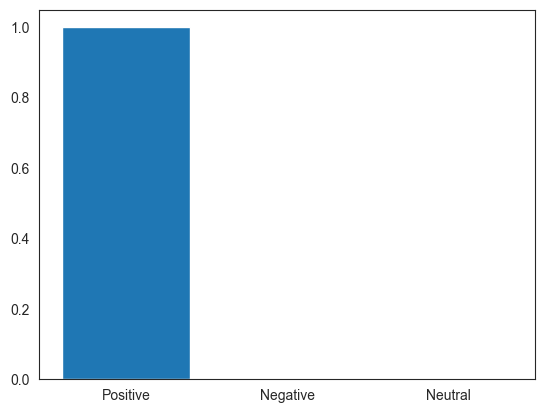

In [60]:
plt.bar(sentiments,scores)

In [92]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline
from transformers import pipeline
classifier = pipeline("text-classification", model="Sharpaxis/FIN_BERT_sentiment",top_k=None)
def finance_sentiment_predictor(text):
    text = str(text)
    out = classifier(text)[0]
    scores = [sample['score'] for sample in out]
    labels = [sample['label'] for sample in out ]
    label_map = {'LABEL_0':"Negative",'LABEL_1':"Neutral",'LABEL_2':"Positive"}
    sentiments = [label_map[label] for label  in labels]
    print("SCORES")
    for i in range(len(scores)):
        print(f"{sentiments[i]} : {scores[i]:.4f}")
    print(f"Sentiment of text is {sentiments[np.argmax(scores)]}")
    fig = go.Figure(
        data=[go.Bar(x=sentiments,y=scores,marker=dict(color=["red", "blue", "green"]),width=0.3)])
    fig.update_layout(
        title="Sentiment Analysis Scores",
        xaxis_title="Sentiments",
        yaxis_title="Scores",
        template="plotly_dark"
    )
    fig.show()

In [105]:
text = "S&P 500 Looks Headed for Strong 2nd Half of December"
finance_sentiment_predictor(text)

SCORES
Positive : 0.9981
Neutral : 0.0011
Negative : 0.0008
Sentiment of text is Positive
